# Example Code Running

In [1]:
from platform import system as operating_system
# if you run macOS this will install all necessary packages
if operating_system() == 'Darwin':
    %pip install -r mac.pip
if operating_system() == 'Linux':
    %pip install -r linux.pip
if operating_system() == 'Windows':
    %pip install -r windows.pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
from pandas_datareader import data as pdr

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler


## Getting Dependencies

## Setting the stock and length to analysis

In [3]:
import pandas as pd
import datetime as dt

# expecting a str
tag = ['gme']

# expecting pd datetimes or regular datetimes as outlined below
start_date = pd.to_datetime('2020-01-01')
end_date = dt.datetime.today()

## Grabbing the data

In [4]:
from pandas_datareader import data as pdr
import tensorflow as tf # This code has been tested with TensorFlow 1.6

df = ''
try:
    # get it from yahoo
    print('downloading data from yahoo')
    df = pdr.get_data_yahoo(tag, start=start_date, end=end_date)
    # reset the index to remove extra symbols
    print('reseting index')
    df.reset_index(inplace=True,drop=False)
    # create a shorter data string
    print('making a short date string')
    df['Date_String'] = data['Date'].dt.strftime('%Y-%m-%d') 
    # drop un needed columns
    print('dropping un needed columns')
    df = data.drop(["Adj Close", "Volume"], axis = 1)

except :
    # if the data is wrong, return a blank one 
    print('We encountered an error please check that your tag is correct ie \ntag = ["gme"]')

downloading data from yahoo
reseting index
making a short date string
We encountered an error please check that your tag is correct ie 
tag = ["gme"]


## Generating the predictive model

In [5]:
# pulls out data into seperate df for ease of use
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0


In [6]:
# splits the data into a training and test
size = int(len(mid_prices) * (3/4))
train_data = mid_prices[:size]
test_data = mid_prices[size:]

## Min Max Scaler (Test 1)

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Select model & reshape data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [8]:
# Dynamically change smoothing settings based on data size
smoothing_window_size = len(mid_prices) - size


In [9]:
# fit data into the model
for di in range(0, int(size * .9),smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])


In [10]:
# data sometimes needs the last section also normalized
try:
    scaler.fit(train_data[smoothing_window_size:,:])
except :
    print('All data already fixed')


In [11]:
# transofrm data for the scaler
try:
    train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])
except :
    None

In [12]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [13]:
# Exponential Smoothing
EMA = 0.0
gamma = 0.1

for ti in range(size):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

In [14]:
# saving here to make visualizations easier later
import numpy as np

all_mid_data = np.concatenate([train_data,test_data],axis=0)

## Running Averages

In [15]:
# Setups

window_size = int(size * .1) # sets windows to 1/10 the real size
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

In [16]:
for pred_idx in range(1,N):
    if pred_idx >= N: # safe check to see if we mathc
        date = dt.datetime.strptime(pred_idx, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else: # grabs as nromal
        date = df.loc[pred_idx,'Date']

    # calcuates the running mean
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    # adds relvant data to its proper location
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

MSE error for EMA averaging: 0.00056


KeyError: 'Date_String'

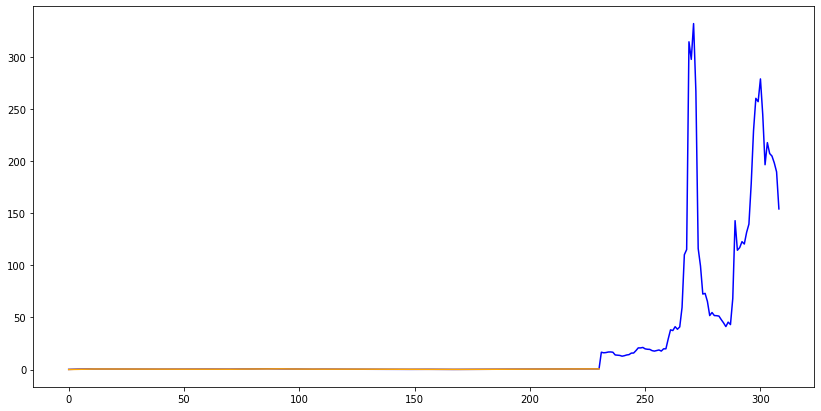

In [17]:
# Report & Plot
import matplotlib.pyplot as plt

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

plt.figure(figsize = (14,7))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
try:
    plt.xticks(range(0,df.shape[0],50),df['Date_String'].loc[::50],rotation=45)
except :
    plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=12)
plt.show()